# CAB420 Practical 7 - Question 1 Solution
## Deep Face Recognition

Using the YaleB_32x32.mat data, train a Siamese network to match faces of the same subject. In doing this you should:
* Determine your network architecture, i.e. pairs or triplets, and loss formulation. You may also wish to fine tune an existing network.
* Implement (or modify) an appropriate method to generate pairs/triplets of images, and verify that this is generating pairs/triplets as expected.

Using your trained network, evaluate it and compare the performance to the PCA and LDA approaches from last week. Note that you can train a CKNN classifier to replicate the functionality of last week's approaches by:
* Passing each image through the network to generate an embedding;
* Applying CKNN to the embeddings.

As per last week, evaluate the performance on the Yale and ORL datasets.

### Relevant Examples


Any of the metric learning examples are relevant here:
* ``CAB420_Metric_Learning_Example_1_Siamese_Networks.ipynb``
* ``CAB420_Metric_Learning_Example_2_Contrastive_Loss.ipynb``
* ``CAB420_Metric_Learning_Example_3_Triplet_Loss.ipynb``

I would suggest either the contrastive or triplet examples as better ones to work off as they will give better performance, are more interesting to work with, and actually are a bit easier to setup (although perhaps more conceptually complex). If you haven't gone through last weeks prac with PCA and LDA, then the solutions for that prac may also be worth a look as we take the same problem from that prac and use deep networks here.

### Suggested Packages

It's mostly tensorflow and keras again here, with our usual support from matplotlib and sklearn.

In [1]:
import os
# why is this here? This is disabling some tensorflow warning I get in some of my environments that 
# annoy me (look ugly and untidy really)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random
import numpy
import numpy.matlib
import scipy
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, Input, Flatten
from keras import activations
from keras.regularizers import l2

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# for consistency
random.seed(4)

### Part 1: Data Setup

This is a variation on how we've handeled the data for the dimension reduction prac. Here we will:
* Load the data
* Scale the image data to [0..1]
* Select some subjects for the test set and split the data
* Create a reshaped version of the data to get the data into an 'image' shape for input to our deep net

In [2]:
yale_b = scipy.io.loadmat('YaleB_32x32.mat')
fea = yale_b['fea'] / 255.0
gnd = numpy.array(yale_b['gnd'])

In [3]:
train_indexes = numpy.where(gnd < 29)[0]

train_fea = fea[train_indexes, :]
train_gnd = gnd[train_indexes, :]

test_fea = fea
test_gnd = gnd
test_fea = numpy.delete(test_fea, train_indexes, 0)
test_gnd = numpy.delete(test_gnd, train_indexes, 0)

print(train_fea.shape)
print(train_gnd.shape)
print(test_fea.shape)
print(test_gnd.shape)

rng = numpy.random.default_rng(4)

probe_frames = numpy.array(()).astype('int')
for i in numpy.unique(test_gnd):    
    indexes = numpy.where(test_gnd == i)[0]
    f = rng.choice(indexes, size=12, replace=False)
    probe_frames = numpy.append(probe_frames, f)

gallery_fea = test_fea
gallery_gnd = test_gnd
gallery_fea = numpy.delete(gallery_fea, probe_frames, 0)
gallery_gnd = numpy.delete(gallery_gnd, probe_frames, 0)
probe_fea = test_fea[probe_frames, :]
probe_gnd = test_gnd[probe_frames, :]

train_gnd = numpy.reshape(train_gnd, -1)
gallery_gnd = numpy.reshape(gallery_gnd, -1)
probe_gnd = numpy.reshape(probe_gnd, -1)

print(gallery_fea.shape)
print(gallery_gnd.shape)
print(probe_fea.shape)
print(probe_gnd.shape)

(1774, 1024)
(1774, 1)
(640, 1024)
(640, 1)
(520, 1024)
(520,)
(120, 1024)
(120,)


In [4]:
train_fea_reshape = numpy.reshape(train_fea.transpose(), (32, 32, 1, len(train_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
gallery_fea_reshape = numpy.reshape(gallery_fea.transpose(), (32, 32, 1, len(gallery_fea)))
gallery_fea_reshape = numpy.transpose(gallery_fea_reshape, (3, 1, 0, 2))
probe_fea_reshape = numpy.reshape(probe_fea.transpose(), (32, 32, 1, len(probe_fea)))
probe_fea_reshape = numpy.transpose(probe_fea_reshape, (3, 1, 0, 2))

print(train_fea_reshape.shape)
print(gallery_fea_reshape.shape)
print(probe_fea_reshape.shape)

(1774, 32, 32, 1)
(520, 32, 32, 1)
(120, 32, 32, 1)


In [5]:
yale_b = scipy.io.loadmat('YaleB_32x32.mat')
fea = yale_b['fea'] / 255.0
gnd = numpy.array(yale_b['gnd'])

train_indexes = numpy.where(gnd < 29)[0]

train_fea = fea[train_indexes, :]
train_gnd = gnd[train_indexes, :]

test_fea = fea
test_gnd = gnd
test_fea = numpy.delete(test_fea, train_indexes, 0)
test_gnd = numpy.delete(test_gnd, train_indexes, 0)

print(train_fea.shape)
print(train_gnd.shape)
print(test_fea.shape)
print(test_gnd.shape)

rng = numpy.random.default_rng(4)

probe_frames = numpy.array(()).astype('int')
for i in numpy.unique(test_gnd):    
    indexes = numpy.where(test_gnd == i)[0]
    f = rng.choice(indexes, size=12, replace=False)
    probe_frames = numpy.append(probe_frames, f)

gallery_fea = test_fea
gallery_gnd = test_gnd
gallery_fea = numpy.delete(gallery_fea, probe_frames, 0)
gallery_gnd = numpy.delete(gallery_gnd, probe_frames, 0)
probe_fea = test_fea[probe_frames, :]
probe_gnd = test_gnd[probe_frames, :]

train_gnd = numpy.reshape(train_gnd, -1)
gallery_gnd = numpy.reshape(gallery_gnd, -1)
probe_gnd = numpy.reshape(probe_gnd, -1)

print(gallery_fea.shape)
print(gallery_gnd.shape)
print(probe_fea.shape)
print(probe_gnd.shape)

train_fea_yb = train_fea
train_gnd_yb = train_gnd
gallery_fea_yb = gallery_fea
gallery_gnd_yb = gallery_gnd
probe_fea_yb = probe_fea
probe_gnd_yb = probe_gnd

(1774, 1024)
(1774, 1)
(640, 1024)
(640, 1)
(520, 1024)
(520,)
(120, 1024)
(120,)


In [6]:
orl = scipy.io.loadmat('ORL_32x32.mat');
fea = orl['fea'] / 255.0
gnd = numpy.array(orl['gnd'])

train_indexes = numpy.where(gnd < 30)[0]

train_fea = fea[train_indexes, :]
train_gnd = gnd[train_indexes, :]

test_fea = fea
test_gnd = gnd
test_fea = numpy.delete(test_fea, train_indexes, 0)
test_gnd = numpy.delete(test_gnd, train_indexes, 0)

print(train_fea.shape)
print(train_gnd.shape)
print(test_fea.shape)
print(test_gnd.shape)

rng = numpy.random.default_rng(4)

probe_frames = numpy.array(()).astype('int')
for i in numpy.unique(test_gnd):    
    indexes = numpy.where(test_gnd == i)[0]
    f = rng.choice(indexes, size=2, replace=False)
    probe_frames = numpy.append(probe_frames, f)

gallery_fea = test_fea
gallery_gnd = test_gnd
gallery_fea = numpy.delete(gallery_fea, probe_frames, 0)
gallery_gnd = numpy.delete(gallery_gnd, probe_frames, 0)
probe_fea = test_fea[probe_frames, :]
probe_gnd = test_gnd[probe_frames, :]

train_gnd = numpy.reshape(train_gnd, -1)
gallery_gnd = numpy.reshape(gallery_gnd, -1)
probe_gnd = numpy.reshape(probe_gnd, -1)

print(gallery_fea.shape)
print(gallery_gnd.shape)
print(probe_fea.shape)
print(probe_gnd.shape)

train_fea_orl = train_fea
train_gnd_orl = train_gnd
gallery_fea_orl = gallery_fea
gallery_gnd_orl = gallery_gnd
probe_fea_orl = probe_fea
probe_gnd_orl = probe_gnd

(290, 1024)
(290, 1)
(110, 1024)
(110, 1)
(88, 1024)
(88,)
(22, 1024)
(22,)


In [7]:
train_fea = numpy.vstack([train_fea_yb, train_fea_orl])
train_gnd = numpy.hstack([train_gnd_yb, (train_gnd_orl + 28)])
print(train_fea.shape)
print(train_gnd.shape)

gallery_fea = numpy.vstack([gallery_fea_yb, gallery_fea_orl])
gallery_gnd = numpy.hstack([gallery_gnd_yb, (gallery_gnd_orl + 28)])
probe_fea = numpy.vstack([probe_fea_yb, probe_fea_orl])
probe_gnd = numpy.hstack([probe_gnd_yb, (probe_gnd_orl + 28)])

(2064, 1024)
(2064,)


In [8]:
train_fea_reshape = numpy.reshape(train_fea.transpose(), (32, 32, 1, len(train_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
gallery_fea_reshape = numpy.reshape(gallery_fea.transpose(), (32, 32, 1, len(gallery_fea)))
gallery_fea_reshape = numpy.transpose(gallery_fea_reshape, (3, 1, 0, 2))
probe_fea_reshape = numpy.reshape(probe_fea.transpose(), (32, 32, 1, len(probe_fea)))
probe_fea_reshape = numpy.transpose(probe_fea_reshape, (3, 1, 0, 2))

print(train_fea_reshape.shape)
print(gallery_fea_reshape.shape)
print(probe_fea_reshape.shape)

(2064, 32, 32, 1)
(608, 32, 32, 1)
(142, 32, 32, 1)


For the sake of sanity, we'll visualise the data to make sure that our reshape has worked. Note that you should always check these things - it's very easy to make a mistake.

We'll run this check on both the training and testing sets.

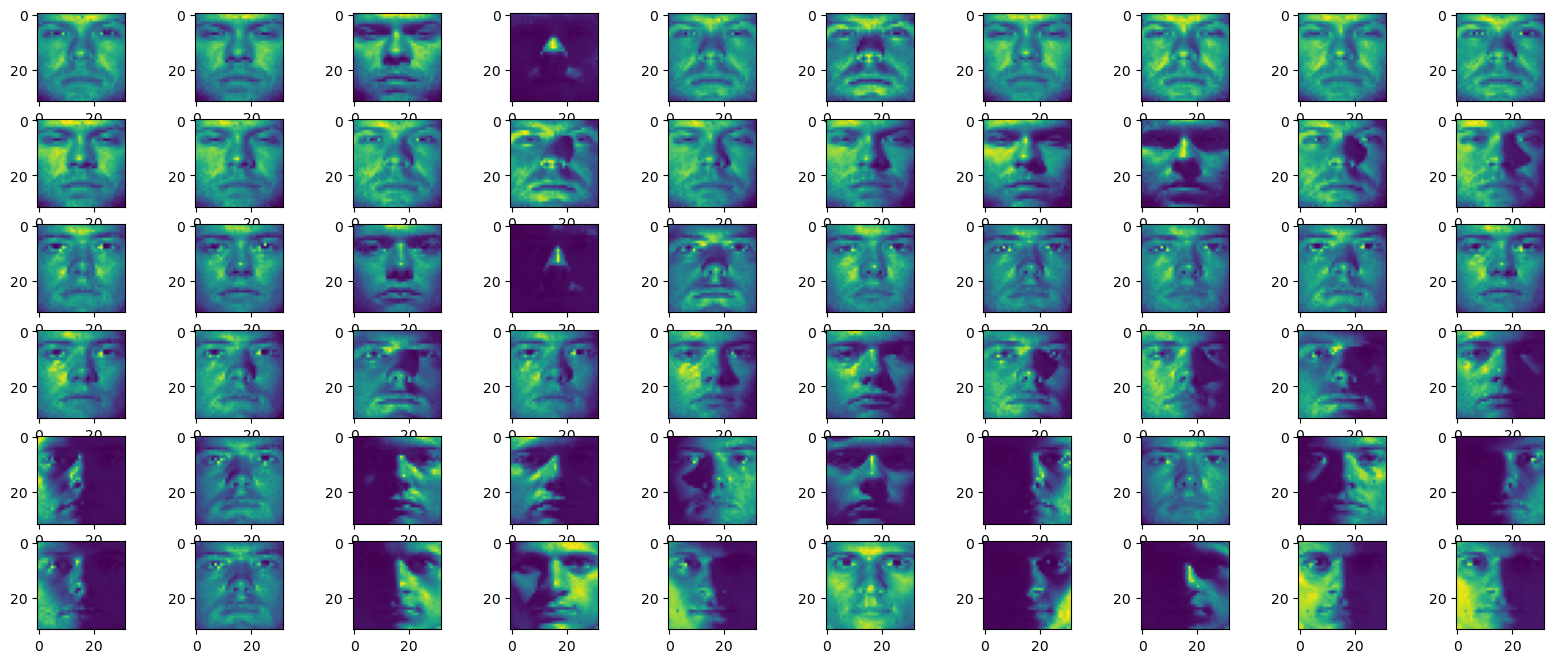

In [9]:
fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(6, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
    
for i in range(20):
    ax = fig.add_subplot(6, 10, i + 21)
    ax.imshow(gallery_fea_reshape[i,:,:,0])    
    
for i in range(20):
    ax = fig.add_subplot(6, 10, i + 41)
    ax.imshow(probe_fea_reshape[i,:,:,0])        

### Network Helper Functions

These are all taken from the Metric Learning examples listed in the intro above. We have a mix of functions to generate pairs/triplets, some network building functions (I've just included the VGG-like functions, but feel free to grab the ResNet functions and use those instead), and an eval function.

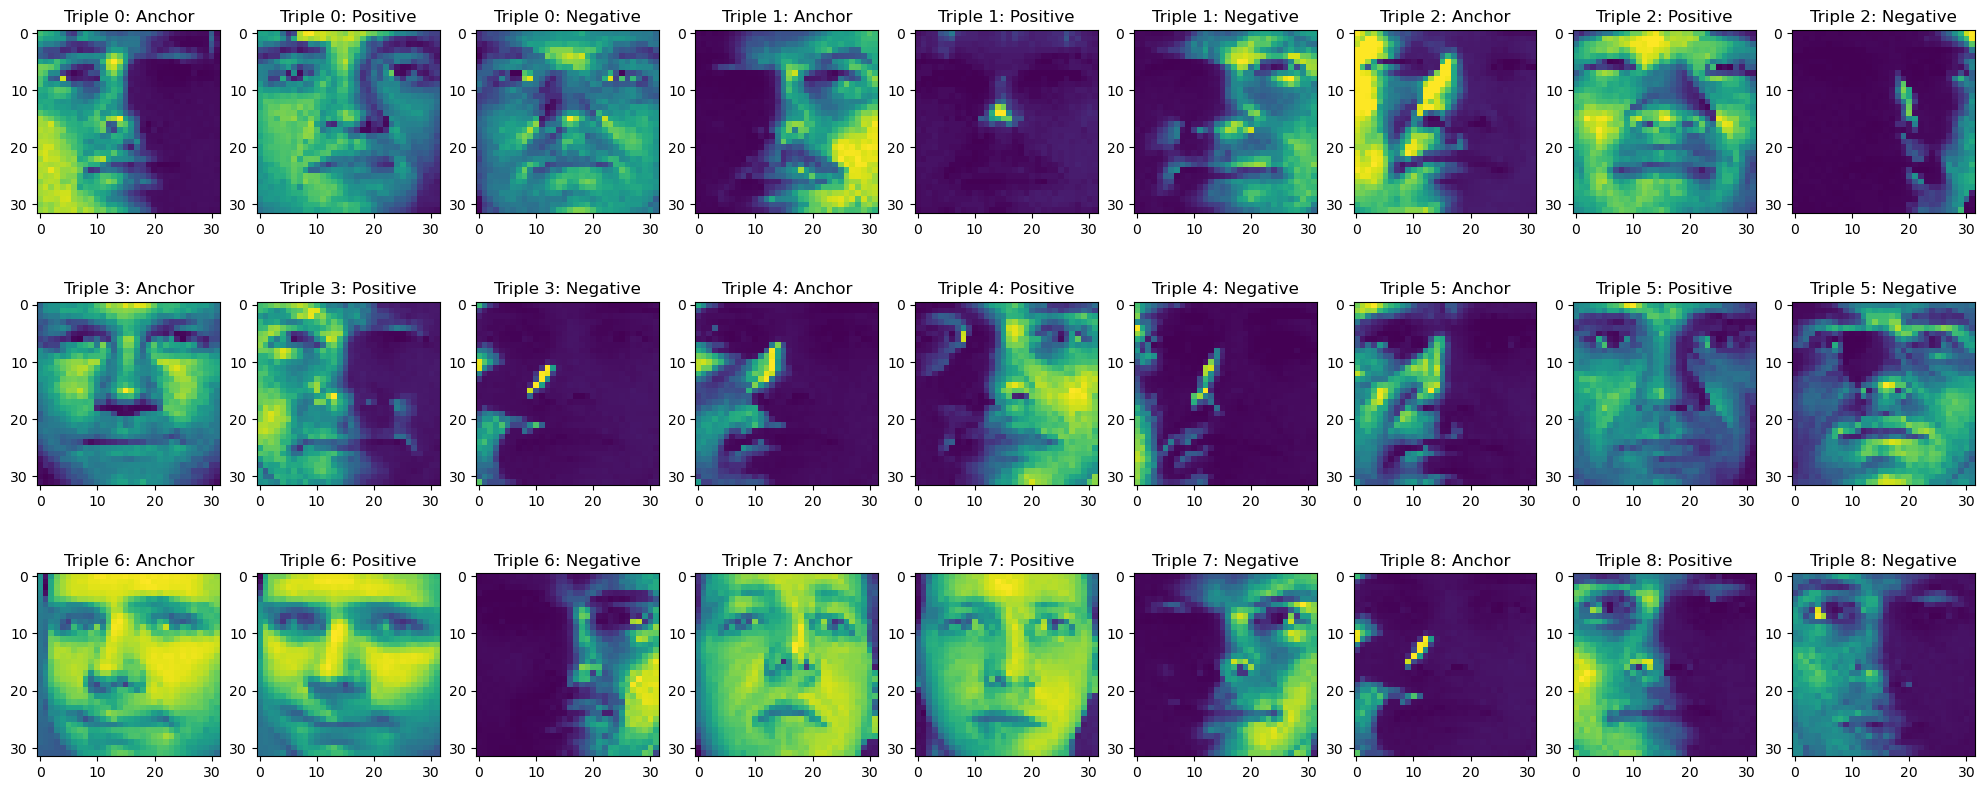

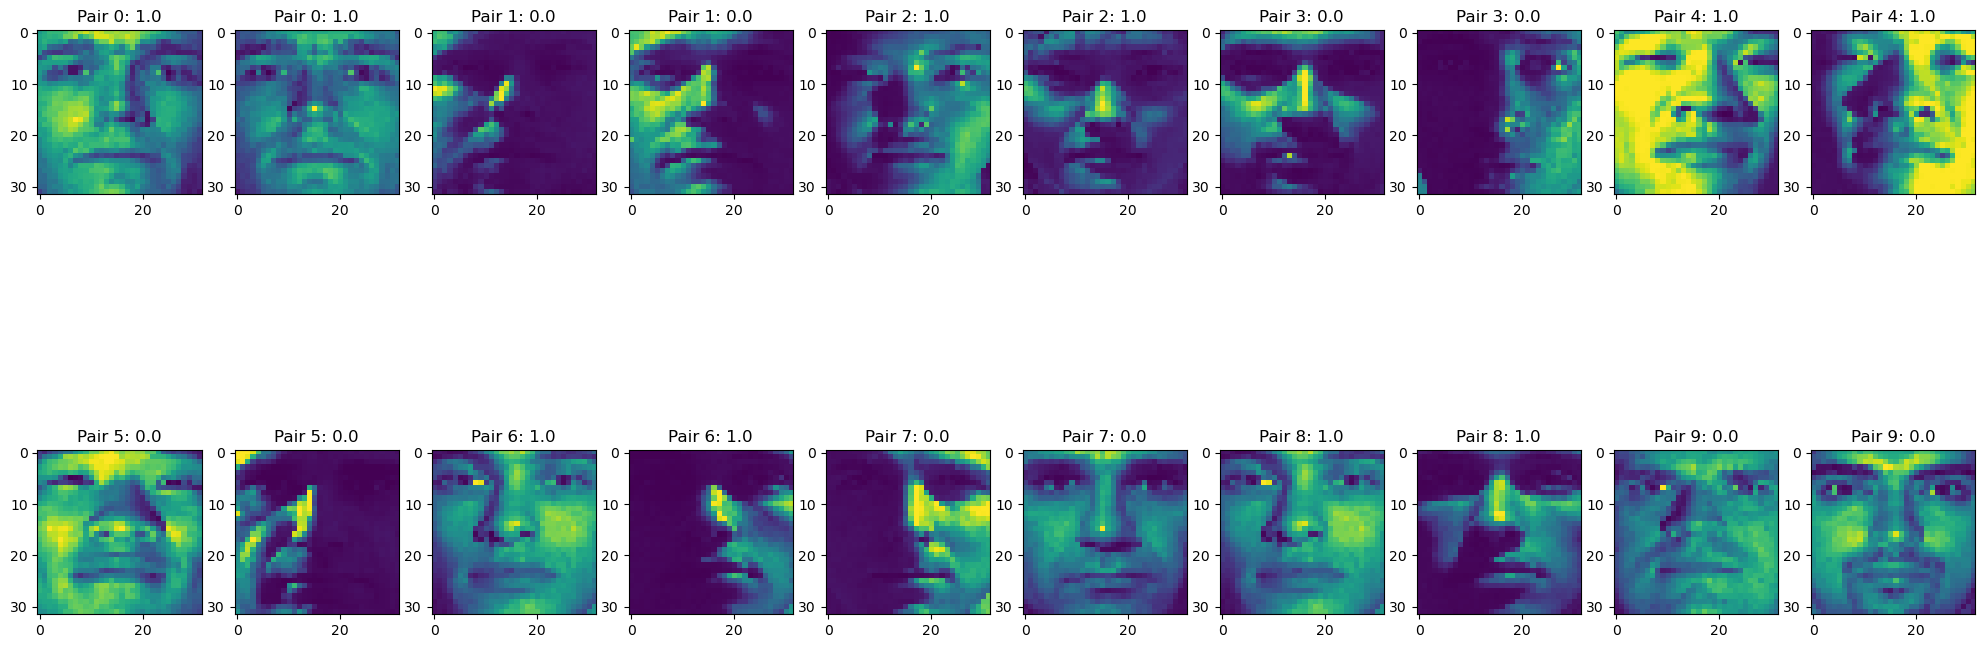

In [10]:
def GetSiameseData(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    label = numpy.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

def GetTripletData(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_c = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]
       
x = GetTripletData(train_fea_reshape, train_gnd, 9)

fig = plt.figure(figsize=[25, 10])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Triple ' + str(i) + ': Anchor')
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Triple ' + str(i) + ': Positive')

    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,0])    
    ax.set_title('Triple ' + str(i) + ': Negative')        
    
x, y = GetSiameseData(train_fea_reshape, train_gnd, 10)

fig = plt.figure(figsize=[25, 10])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i) + ': ' + str(y[i]))
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Pair ' + str(i) + ': ' + str(y[i]))

In [11]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

def normalise_vector(vect):
    # get the magnitude for each vector in the batch
    mag = keras.ops.sqrt(keras.ops.sum(keras.ops.square(vect), axis=1))
    # repeat this, so we now have as many elements in mag as we do in vect
    mag = keras.ops.reshape(keras.ops.repeat(mag, vect.shape[1], axis=0), (-1, vect.shape[1]))
    # element wise division
    return keras.ops.divide(vect, mag)

def euclidean_distance(vects):
    x, y = vects
    x = normalise_vector(x) # this is just doing x = tf.math.l2_normalize(x, axis=1)
    y = normalise_vector(y) # this is just doing y = tf.math.l2_normalize(y, axis=1)

    sum_square = keras.ops.sum(keras.ops.square(keras.ops.subtract(x, y)), axis=1, keepdims=True)
    return keras.ops.sqrt(keras.ops.maximum(sum_square, keras.config.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = keras.ops.square(y_pred)
    margin_square = keras.ops.square(keras.ops.maximum(margin - y_pred, 0))
    return keras.ops.mean(y_true * square_pred + (1 - y_true) * margin_square)

class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = normalise_vector(anchor)
        positive = normalise_vector(positive)
        negative = normalise_vector(negative)

        p_dist = keras.ops.sum(keras.ops.square(anchor-positive), axis=-1)
        n_dist = keras.ops.sum(keras.ops.square(anchor-negative), axis=-1)
        return keras.ops.sum(keras.ops.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
        
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: %s' % (sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Test Set Performance: %s' % (sum(pred == Y_test)/len(Y_test)));    

In [12]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(inputs, filters, num_res_blocks, pool_size):

    x = resnet_layer(inputs=inputs,
                     num_filters=filters[0])

    # Instantiate the stack of residual units
    for stack, filters in enumerate(filters):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
 
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)

    return y


def resnet_v2(inputs, filters, num_res_blocks, pool_size):

    x = resnet_layer(inputs=inputs,
                     num_filters=filters[0],
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage, filters in enumerate(filters):
        num_filters_in = filters
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)
    return y

### Part 2: Build and Train the Network

From here, you can build, train and evaluate the network. 

For building and training you will need to:
* Decide on your network structure, is it a pair, or a triplet?
* Build the backbone
* Create two/three inputs, pass those through the backbone, and then into your loss function
* Setup your siamese/triplet network
* Train the network

Once that is done, you can:
* Pass the embeddings through the backbone
* Use a CKNN (or other classifier of your choosing) to train a simple Re-ID model
* Evaluate said model

I would suggest it's worth trying both a Contrastive and Triplet formulation and comparing the two.

In [13]:
inputs = keras.layers.Input(shape=(32, 32, 1, ), name='img')
x = resnet_v1(inputs, [16, 32, 64], 2, 7)
output = keras.layers.Dense(32)(x)

backbone = keras.Model(inputs = inputs, outputs = output)
backbone.summary()
backbone.compile(jit_compile = False)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)    │ (None, 32, 32, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        160 │ img[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      2,320 │ activation_1[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ activation[0][0], │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      2,320 │ activation_2[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      2,320 │ activation_3[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ activation_2[0][… │
│                     │ 16)               │            │ batch_normalizat

 Total params: 177,696 (694.12 KB)

 Trainable params: 176,768 (690.50 KB)

 Non-trainable params: 928 (3.62 KB)

In [14]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.05),
  layers.RandomZoom(0.025),
  layers.RandomTranslation(height_factor=(-0.025, 0.025), width_factor=(-0.025, 0.025))
])

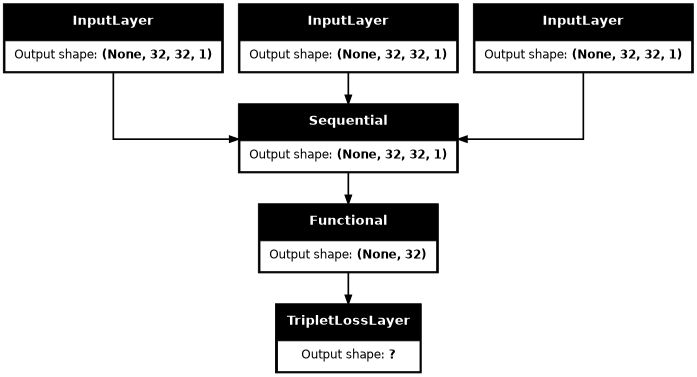

In [15]:
inputs_a = keras.layers.Input(shape=(32, 32, 1, ), name='img_a')
inputs_p = keras.layers.Input(shape=(32, 32, 1, ), name='img_p')
inputs_n = keras.layers.Input(shape=(32, 32, 1, ), name='img_n')

augmented_a = data_augmentation(inputs_a)
augmented_p = data_augmentation(inputs_p)
augmented_n = data_augmentation(inputs_n)

embedding_a = backbone(augmented_a)
embedding_p = backbone(augmented_p)
embedding_n = backbone(augmented_n)

margin = 1
loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')(
    [embedding_a, embedding_p, embedding_n])

triplet_network = keras.Model([inputs_a, inputs_p, inputs_n], loss_layer)
keras.utils.plot_model(triplet_network, show_shapes=True, dpi = 60, expand_nested=False)

In [16]:
# note I'm selecting no metrics here, accuracy doesn't make sense for the way that we're training the model
triplet_network.compile(optimizer=keras.optimizers.AdamW(), metrics=[], jit_compile=False)

triplet_test_x = GetTripletData(gallery_fea_reshape, gallery_gnd, 10000)
for i in range(5):
    triplet_train_x = GetTripletData(train_fea_reshape, train_gnd, 60000)
    triplet_network.fit(triplet_train_x, y=None, batch_size = 128, epochs=1, 
                        validation_data = (triplet_test_x, None))

469/469 ━━━━━━━━━━━━━━━━━━━━ 99s 173ms/step - loss: 78.3280 - val_loss: 59.9042
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 179ms/step - loss: 36.5647 - val_loss: 56.7458
469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 156ms/step - loss: 19.9016 - val_loss: 55.5610
469/469 ━━━━━━━━━━━━━━━━━━━━ 72s 153ms/step - loss: 14.5998 - val_loss: 42.1951
469/469 ━━━━━━━━━━━━━━━━━━━━ 72s 153ms/step - loss: 10.8266 - val_loss: 39.7084


In [17]:
train_embeddings = backbone.predict(train_fea_reshape)
gallery_embeddings = backbone.predict(gallery_fea_reshape)
probe_embeddings = backbone.predict(probe_fea_reshape)

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


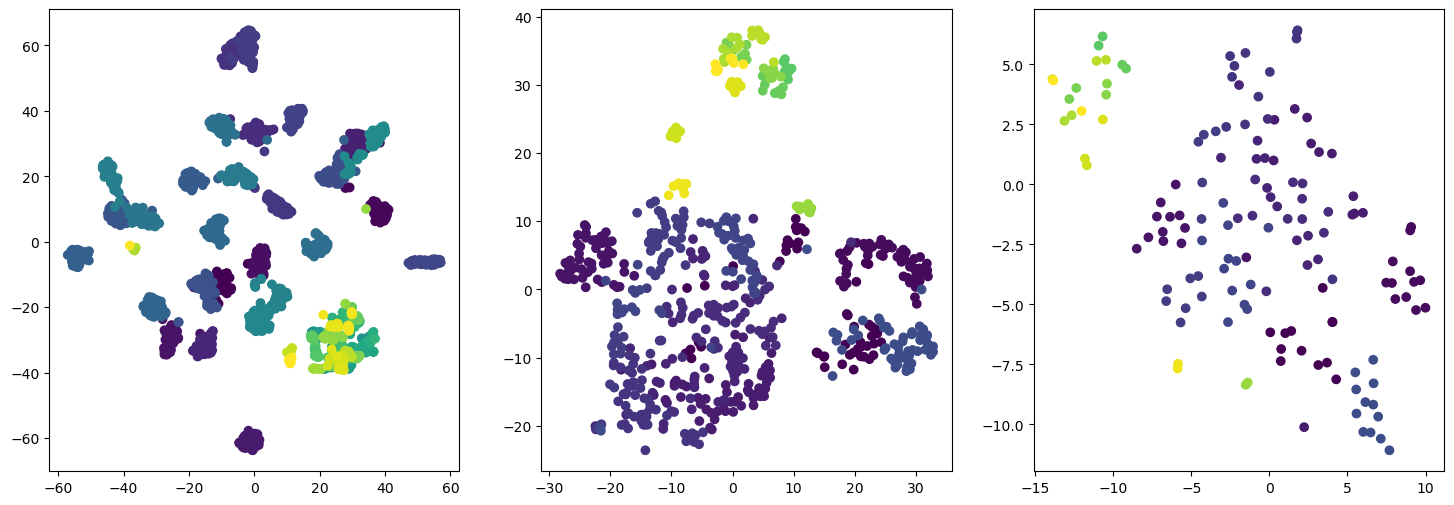

In [18]:
fig = plt.figure(figsize=[18, 6])
tsne_embeddings = TSNE(random_state=42).fit_transform(train_embeddings)
ax = fig.add_subplot(1, 3, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_gnd.flatten());

tsne_embeddings = TSNE(random_state=42).fit_transform(gallery_embeddings)
ax = fig.add_subplot(1, 3, 2)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = gallery_gnd.flatten());

tsne_embeddings = TSNE(random_state=42).fit_transform(probe_embeddings)
ax = fig.add_subplot(1, 3, 3)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = probe_gnd.flatten());

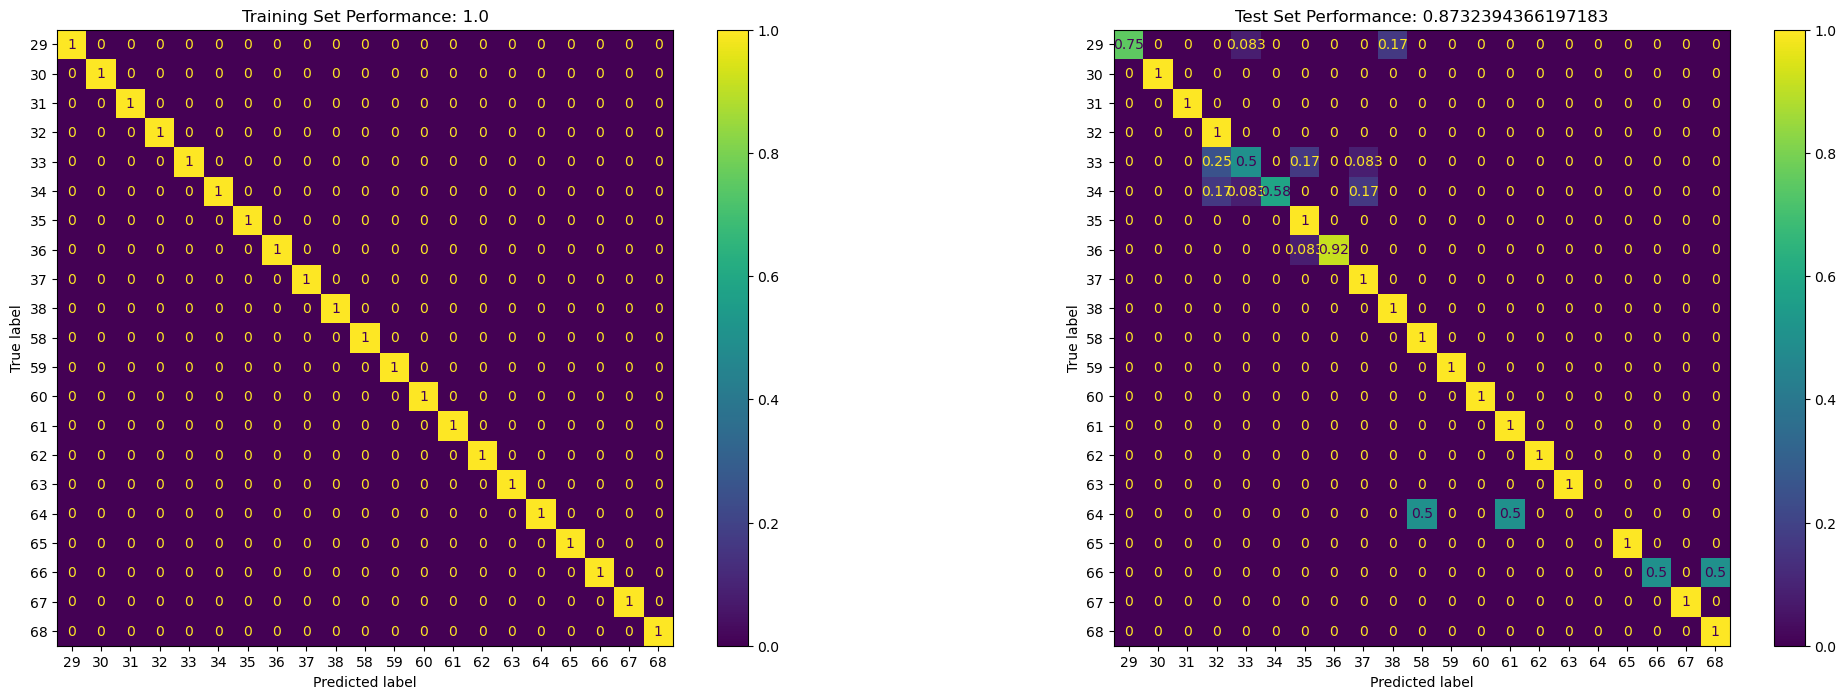

In [19]:
cknn = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn.fit(gallery_embeddings, gallery_gnd)
eval_model(cknn, gallery_embeddings, gallery_gnd, probe_embeddings, probe_gnd)

### Part 3: Does it Generalise?

Now, evalute the trained model on our other datasets. For both datasets the process is:
* Load the data and get into the right format for Keras (this is done for you)
* Pass the data through the backbone to get embeddings
* Use a CKNN (or other classifier of your choosing) to train a simple Re-ID model
* Evaluate said model

#### ORL Data Loading

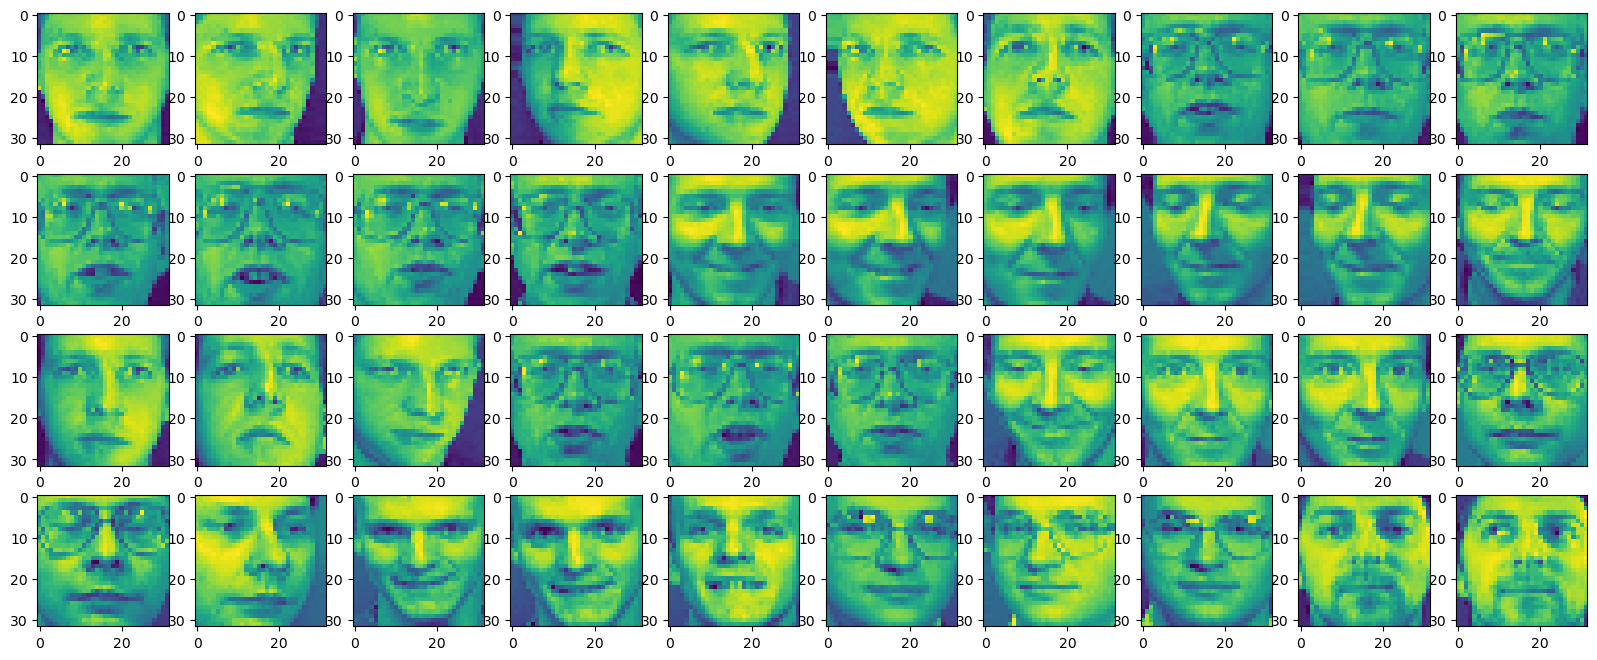

In [20]:
orl = scipy.io.loadmat('ORL_32x32.mat');
fea = orl['fea'] / 255.0
gnd = numpy.array(orl['gnd'])

train_frames = []
for i in range(40):
    for j in range(7):
        train_frames.append(i*10 + j)
        
train_orl_fea = fea[train_frames, :]
train_orl_gnd = gnd[train_frames, :]
test_orl_fea = fea
test_orl_gnd = gnd
test_orl_fea = numpy.delete(test_orl_fea, train_frames, 0)
test_orl_gnd = numpy.delete(test_orl_gnd, train_frames, 0)
train_orl_gnd = numpy.reshape(train_orl_gnd, -1)
test_orl_gnd = numpy.reshape(test_orl_gnd, -1)

train_fea_reshape = numpy.reshape(train_orl_fea.transpose(), (32, 32, 1, len(train_orl_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_orl_fea.transpose(), (32, 32, 1, len(test_orl_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])    

#### Evaluate the ORL data using the Siamese network

In [21]:
gallery_embeddings = backbone.predict(train_fea_reshape)
probe_embeddings = backbone.predict(test_fea_reshape)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


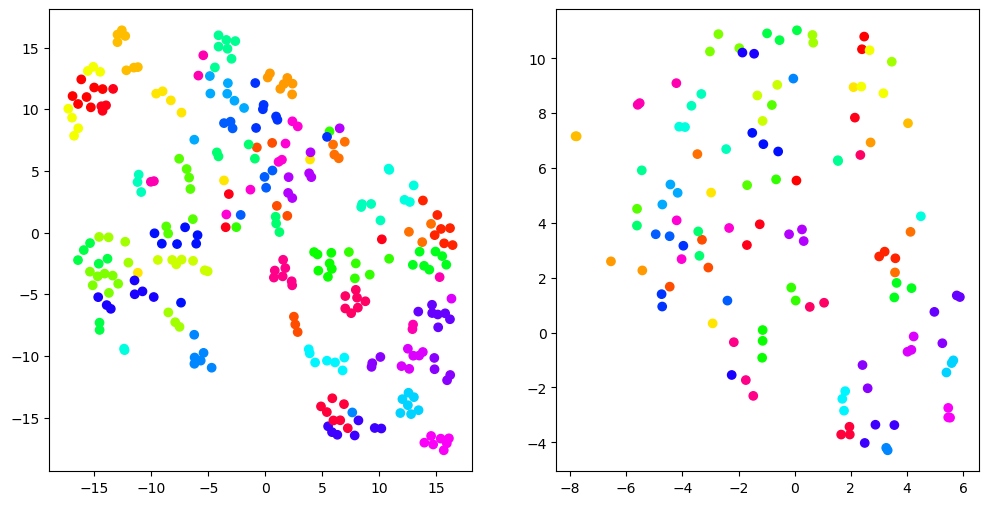

In [22]:
fig = plt.figure(figsize=[12, 6])
tsne_embeddings = TSNE(random_state=42).fit_transform(gallery_embeddings)
ax = fig.add_subplot(1, 2, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_orl_gnd.flatten(), cmap='hsv');

tsne_embeddings = TSNE(random_state=42).fit_transform(probe_embeddings)
ax = fig.add_subplot(1, 2, 2)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = test_orl_gnd.flatten(), cmap='hsv');

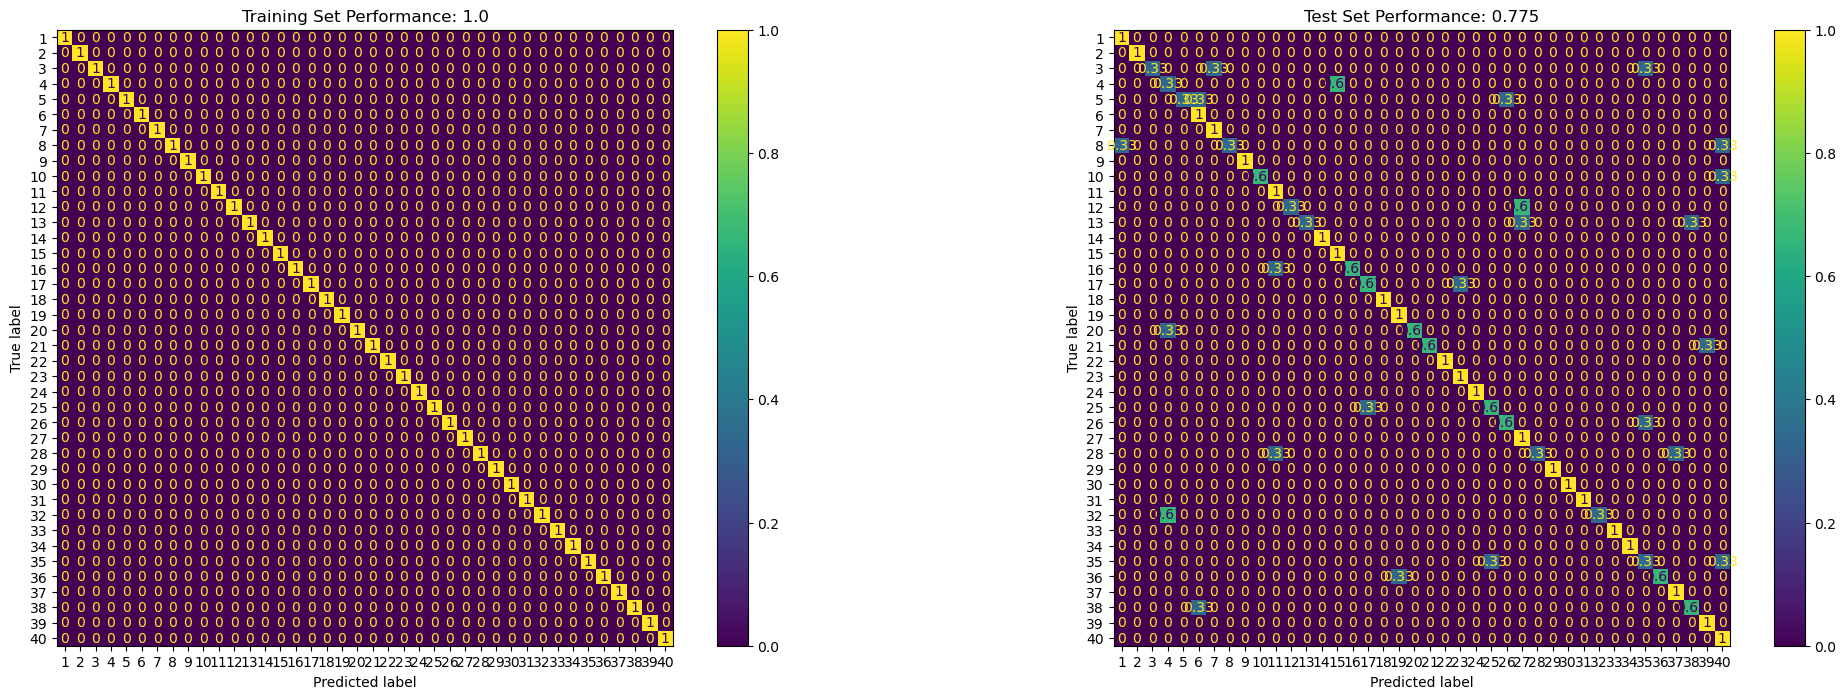

In [23]:
cknn = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn.fit(gallery_embeddings, train_orl_gnd)
eval_model(cknn, gallery_embeddings, train_orl_gnd, probe_embeddings, test_orl_gnd)

#### Yale Data Loading

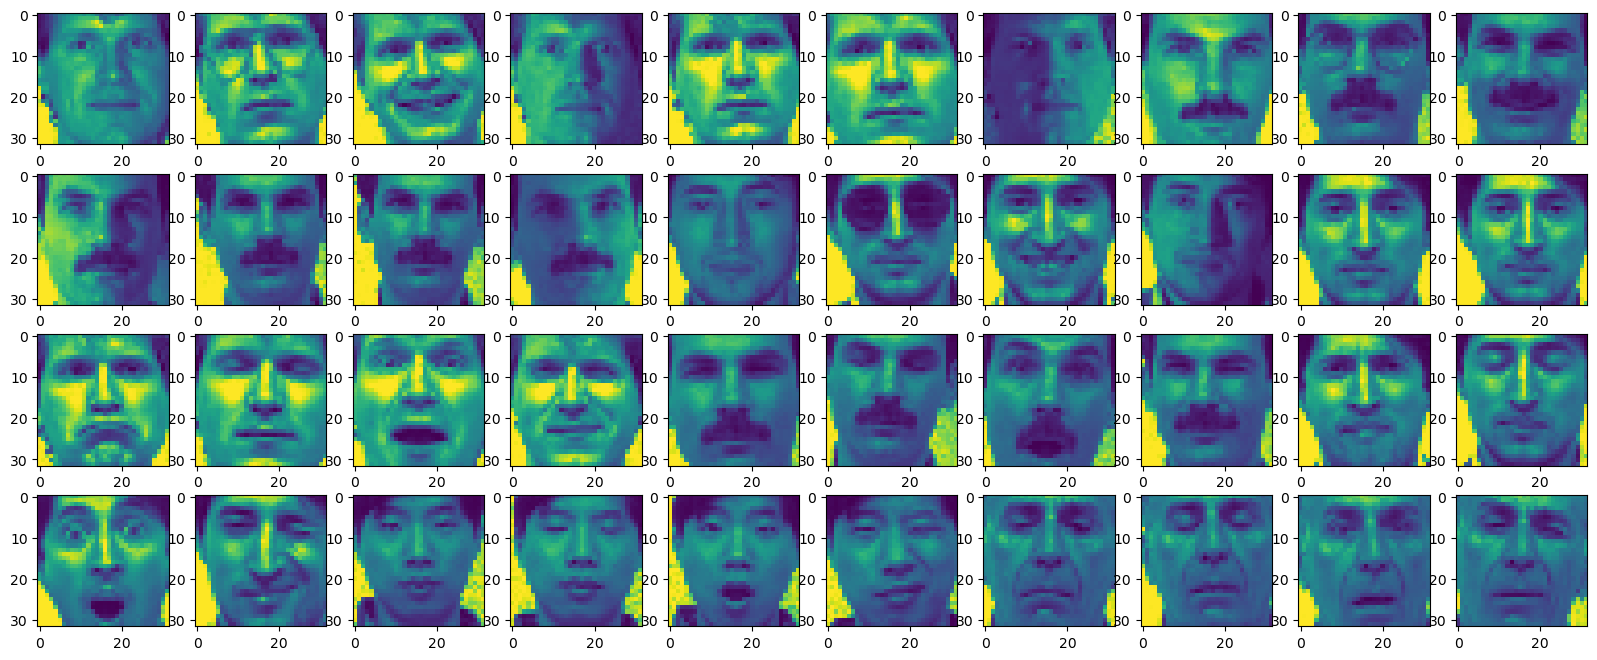

In [24]:
yale = scipy.io.loadmat('Yale_32x32.mat');
fea = yale['fea'] / 255.0
gnd = numpy.array(yale['gnd'])

train_frames = []
for i in range(15):
    for j in range(7):
        train_frames.append(i*11 + j)

train_yale_fea = fea[train_frames, :]
train_yale_gnd = gnd[train_frames, :]
test_yale_fea = fea
test_yale_gnd = gnd
test_yale_fea = numpy.delete(test_yale_fea, train_frames, 0)
test_yale_gnd = numpy.delete(test_yale_gnd, train_frames, 0)
train_yale_gnd = numpy.reshape(train_yale_gnd, -1)
test_yale_gnd = numpy.reshape(test_yale_gnd, -1)

train_fea_reshape = numpy.reshape(train_yale_fea.transpose(), (32, 32, 1, len(train_yale_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_yale_fea.transpose(), (32, 32, 1, len(test_yale_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])   

#### Evaluate Yale using the Siamese Network

In [25]:
gallery_embeddings = backbone.predict(train_fea_reshape)
probe_embeddings = backbone.predict(test_fea_reshape)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step 


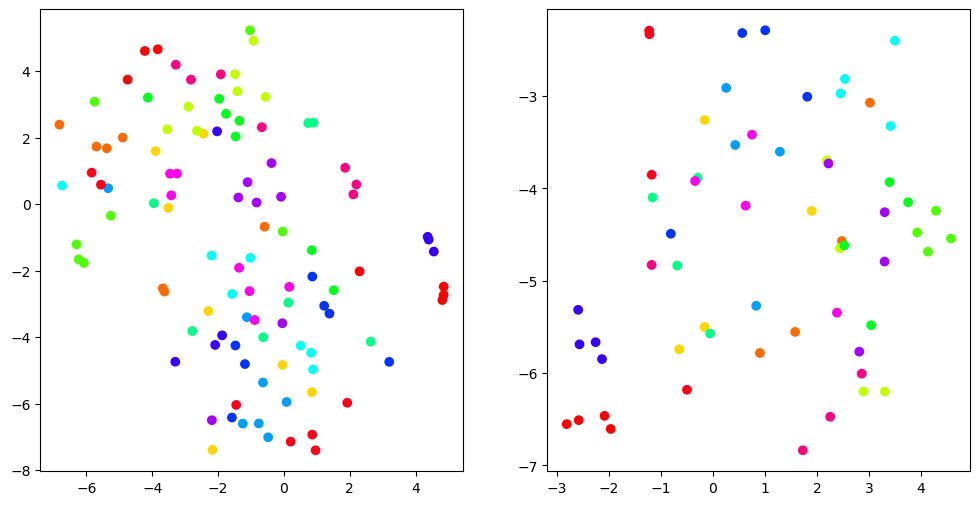

In [26]:
fig = plt.figure(figsize=[12, 6])
tsne_embeddings = TSNE(random_state=42).fit_transform(gallery_embeddings)
ax = fig.add_subplot(1, 2, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_yale_gnd.flatten(), cmap='hsv');

tsne_embeddings = TSNE(random_state=42).fit_transform(probe_embeddings)
ax = fig.add_subplot(1, 2, 2)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = test_yale_gnd.flatten(), cmap='hsv');

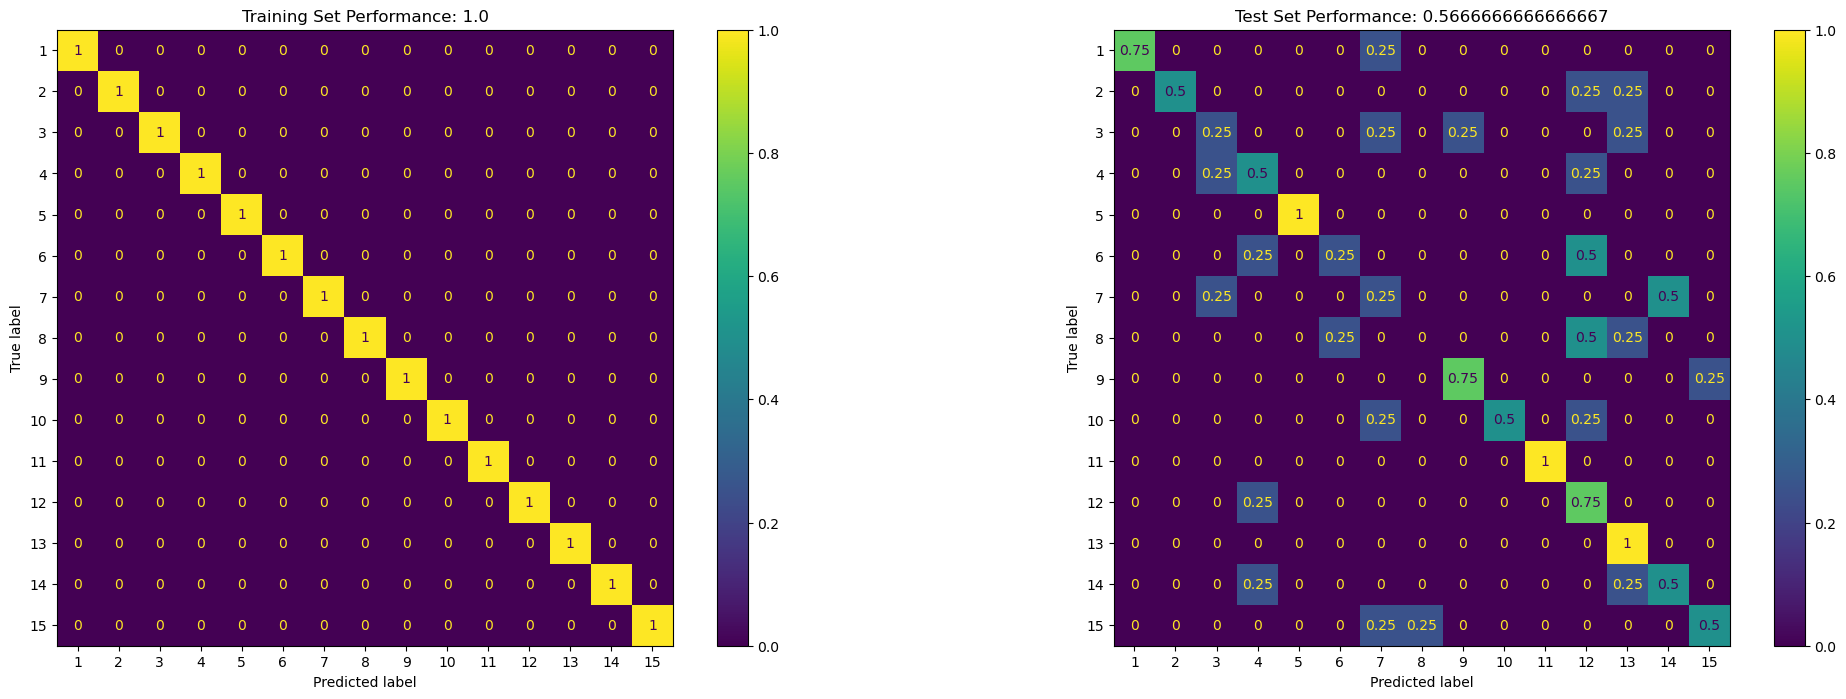

In [27]:
cknn = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn.fit(gallery_embeddings, train_yale_gnd)
eval_model(cknn, gallery_embeddings, train_yale_gnd, probe_embeddings, test_yale_gnd)